<a href="https://colab.research.google.com/github/sujitpal/nlp-deeplearning-ai-examples/blob/master/blog_tds_fd905cb22df7_bert_embeddings_wsd.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# WSD using BERT Raw Embeddings

This notebook explores an idea proposed by Ajit Rakasekharan in his blog post [Examining BERT raw embeddings](https://towardsdatascience.com/examining-berts-raw-embeddings-fd905cb22df7). It is well-known that transformers yield "contextual" embeddings for words, unlike word-embeddings. The blog post proposes the idea that it should be possible to disambiguate [homonyms/homographs](https://www.insider.com/words-spelled-same-different-meanings-2019-1), i.e., words that sound and spelled the same but mean different things depending on context, based on their location and proximity to other words in the embedding space.

We use the [HuggingFace BERTModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) with weights from a `bert-base-cased` pre-trained model for our experiment.

For a given homonym/homograph, we will identify several sentences that mention these in different contexts. We will then capture their "before" and "after" embeddings, i.e. the embeddings for the word from the first and last hidden states of the model, and then compare it (cosine similarity) with all other words in the model vocabulary.

We expect to observe, for each distinct context:
* different distributions of similarity values, and
* different distribution of similar words.




## Environment setup

In [1]:
!pip install transformers

     |████████████████████████████████| 1.4MB 6.8MB/s 
     |████████████████████████████████| 2.9MB 34.7MB/s 
     |████████████████████████████████| 890kB 38.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=f4a6a59338fb05de99192c1848f840deb373299b831848eef3c3755223e624d5
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch

from transformers import BertModel, BertTokenizer

%matplotlib inline

## Load pre-trained model

We choose the pre-trained `bert-base-cased` model because the blog post reports good results with it.

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
model = BertModel.from_pretrained('bert-base-cased', return_dict=True)

### Hidden States

We want our model to return the hidden states, so we can capture them. The `output_hidden_states` parameter needs to be set to True for this.

There are 13 hidden states, the first corresponding to the embedding (projecting the vocabulary word to the (768,) embedding) and the rest corresponding to the 12 layers in the BERT-base model.

Output of each hidden state is `(batch_size, number_of_tokens, 768)`.

In [4]:
text = "Conan went to a prison cell."
inputs = tokenizer(text, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)

In [5]:
outputs

BaseModelOutputWithPoolingAndCrossAttentions([('last_hidden_state',
                                               tensor([[[ 0.3345, -0.0393,  0.0458,  ...,  0.0241,  0.0804,  0.0365],
                                                        [ 0.0278, -0.5531,  0.5972,  ...,  0.2188, -0.1919,  0.0281],
                                                        [ 0.2310,  0.1144,  0.2451,  ...,  0.4046, -0.1479,  0.1663],
                                                        ...,
                                                        [ 0.1710,  0.1697,  0.0063,  ...,  0.2594,  0.0258,  0.0875],
                                                        [ 0.2277, -0.3697,  0.1023,  ...,  0.3099, -0.0642, -0.1183],
                                                        [ 0.8567,  0.1250, -0.6334,  ...,  0.4787,  0.1390, -0.1556]]],
                                                      grad_fn=<NativeLayerNormBackward>)),
                                              ('pooler_output',
      

In [6]:
len(outputs.hidden_states)

13

In [7]:
# first hidden layer
outputs.hidden_states[0].size()

torch.Size([1, 9, 768])

In [8]:
# last hidden layer
outputs.hidden_states[-1].size()

torch.Size([1, 9, 768])

### Vocabulary and Embeddings

We want to compare the input and output embeddings for the homonym/homograph word against all words in the vocabulary.

We can find the number of words in the vocabulary, and for each position in this range, we can call `tokenizer.convert_ids_to_tokens` to find the equivalent token value.

The embedding for each word (without context) is given by the embedding layer in the model. The base embedding corresponding to a given vocabulary word is the just the row identified by its ID.

In [9]:
vocab_size = model.config.vocab_size
vocab_size

28996

In [10]:
tokenizer.convert_ids_to_tokens(np.random.randint(1000, high=vocab_size))

'Foley'

In [11]:
embedding = model.embeddings.word_embeddings
E = embedding.weight
E.size()

torch.Size([28996, 768])

## Test Sentences



In [12]:
sentences = [
  "Go to the bank and deposit your pay check.",
  "Jim and Janet went down to the river bank to admire the swans."
]

In [13]:
def get_token_id(sentence, token, show_tokens=False):
  tokens = tokenizer.convert_ids_to_tokens(tokenizer(sentence).input_ids)
  idx = [idx for idx, tok in enumerate(tokens) if tok == token]
  if show_tokens:
    print(tokens)
  return -1 if len(idx) == 0 else idx[0]


get_token_id(sentences[0], "bank", show_tokens=True)

['[CLS]', 'Go', 'to', 'the', 'bank', 'and', 'deposit', 'your', 'pay', 'check', '.', '[SEP]']


4

In [14]:
def compute_cosine_similarity(x1, x2):
  x1 = x1.reshape(1, -1)
  x2 = x2.reshape(1, -1)
  return torch.nn.CosineSimilarity()(x1, x2).item()


x1 = torch.randn(768)
x2 = torch.randn(768)
compute_cosine_similarity(x1, x2)

-0.011603300459682941

### Cosine Similarity Distributions

In [15]:
def compute_cosine_similarities_for_token(sentence, token):
  inputs = tokenizer(sentence, return_tensors="pt")
  outputs = model(**inputs, output_hidden_states=True)
  # size of embeds_*: (sentence_id=1, num_tokens, 768)
  embeds_in, embeds_out = outputs.hidden_states[0], outputs.hidden_states[-1]
  token_id = get_token_id(sentence, token)
  # size of tok_embed_*: (768)
  tok_embed_in, tok_embed_out = embeds_in[0, token_id, :], embeds_out[0, token_id, :]
  cosims_in = [compute_cosine_similarity(tok_embed_in, E[i]) for i in range(E.size(0))]
  cosims_out = [compute_cosine_similarity(tok_embed_out, E[i]) for i in range(E.size(0))]
  return cosims_in, cosims_out


cosims_in_0, cosims_out_0 = compute_cosine_similarities_for_token(sentences[0], "bank")

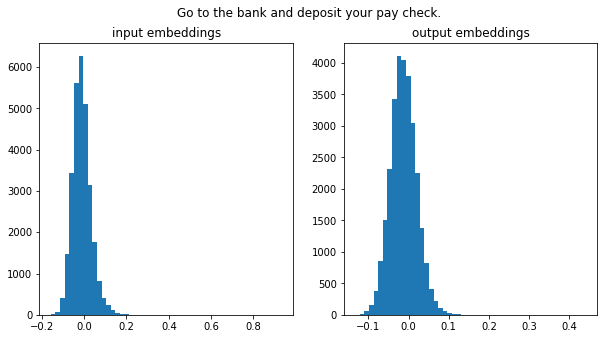

In [16]:
def plot_cosine_similarity_distribution(cosims_in, cosims_out, sentence):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.title("input embeddings")
  plt.hist(cosims_in, bins=50)
  
  plt.subplot(1, 2, 2)
  plt.title("output embeddings")
  plt.hist(cosims_out, bins=50)

  plt.suptitle(sentence)
  
  _ = plt.show()


plot_cosine_similarity_distribution(cosims_in_0, cosims_out_0, sentences[0])

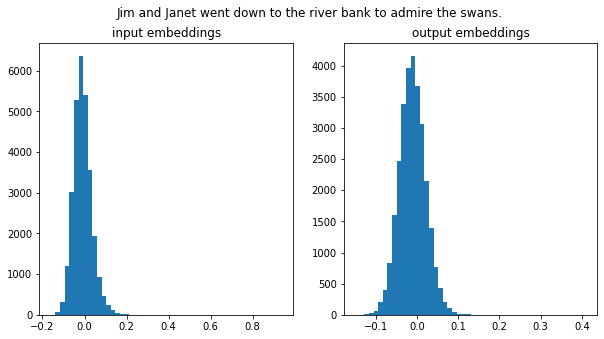

In [17]:
cosims_in_1, cosims_out_1 = compute_cosine_similarities_for_token(sentences[1], "bank")
plot_cosine_similarity_distribution(cosims_in_1, cosims_out_1, sentences[1])

### Top k most similar words

Histograms show that the output embeddings have a long tail in both cases. Terms with high contextual similarity to the input ambiguous term are going to be located on this tail.

Interestingly the length of the tail becomes shorter in both cases on the output embedding side (regressing to the mean as more information becomes available?).

We find contextually similar words based on cosine similarity with the input words. As expected, output embeddings for `bank` in the first sentence show similarity with words related to banking, and output embeddings for `bank` in the second sentence show similarity with words related to river and shore.

In [18]:
def get_top_most_similar_words(cosims, k=10, show_scores=True, show_real_words=True):
  top_k_idxs = np.argsort(cosims)[::-1][0:k+10]
  tokens = tokenizer.convert_ids_to_tokens(top_k_idxs)
  if show_scores:
    top_scores = [cosims[i] for i in top_k_idxs]
    if show_real_words:
      return [(token, score) for token, score in zip(tokens, top_scores) if
              not(token.startswith("[")) and
              not(token.startswith("##")) and
              len(token) > 1][0:k]
    else:
      return [(token, score) for token, score in zip(tokens, top_scores)][0:k]
  else:
    if show_real_words:
      return [token for token in tokens if 
              not(token.startswith("[")) and 
              not(token.startswith("##")) and 
              len(token) > 1][0:k]
    else:
      return tokens[0:k]


get_top_most_similar_words(cosims_in_0)

[('bank', 0.9322858452796936),
 ('banks', 0.6398346424102783),
 ('Bank', 0.5244991183280945),
 ('banking', 0.42404094338417053),
 ('banker', 0.3195374608039856),
 ('Banking', 0.27450740337371826),
 ('Banks', 0.2625081241130829),
 ('shore', 0.24294957518577576),
 ('hotel', 0.22805191576480865),
 ('store', 0.22024661302566528)]

In [19]:
get_top_most_similar_words(cosims_out_0)

[('bank', 0.18816906213760376),
 ('banker', 0.17837834358215332),
 ('her', 0.13340264558792114),
 ('banking', 0.13269563019275665),
 ('Bank', 0.12636975944042206),
 ('car', 0.1258864849805832),
 ('Banking', 0.12153404206037521),
 ('and', 0.11937716603279114),
 ('building', 0.11740049719810486),
 ('the', 0.11648747324943542)]

In [20]:
get_top_most_similar_words(cosims_in_1)

[('bank', 0.9364502429962158),
 ('banks', 0.644376814365387),
 ('Bank', 0.5293071269989014),
 ('banking', 0.42480504512786865),
 ('banker', 0.32117369771003723),
 ('Banking', 0.2746722102165222),
 ('Banks', 0.26500627398490906),
 ('shore', 0.23942628502845764),
 ('hotel', 0.23093190789222717),
 ('store', 0.22488842904567719)]

In [21]:
get_top_most_similar_words(cosims_out_1)

[('river', 0.15005742013454437),
 ('bank', 0.14677192270755768),
 ('shore', 0.14008678495883942),
 ('the', 0.13924647867679596),
 ('running', 0.1298357993364334),
 ('side', 0.128604456782341),
 ('shoreline', 0.12534601986408234),
 ('deer', 0.12421098351478577),
 ('ran', 0.12203148007392883),
 ('one', 0.12113437801599503)]